# A Dirichlet Poisson problem

Now, let's put together a lot of the tools we've discussed earlier
to solve a standard problem: the solution of Laplace's equation,
with Dirichlet boundary conditions on a surface. Our objective is to solve this
problem with one Dirichlet value for the region external to the surface,
and another Dirichlet value internal to the surface.

To be specific, our problem is

$$\nabla^2\varphi^+ = 0,\qquad \nabla^2\varphi^- = 0$$

where $+$ denotes the exterior and $-$ the interior of the surface. (We will
consider a circle of radius 1.) The boundary conditions on this surface are

$$\varphi^+ = x, \qquad \varphi^- = 0$$

In other words, we seek to set the value on the exterior to the local $x$ coordinate
of the surface, while the interior should have zero field.

Discretizing this problem by the techniques developed in [^1], we seek to solve

$$\begin{bmatrix} L & R \\ R^T & 0 \end{bmatrix} \begin{pmatrix} f \\ -s \end{pmatrix} = \begin{pmatrix} D_s d \\ \overline{f}_b \end{pmatrix}$$

where $\overline{f}_b = (f^+_b + f^-_b)/2 = x/2$ and $d = f^+_b - f^-_b = x$.

This saddle-point problem can be solved by block-LU decomposition. First solve

$$L f^{*} = D_s d$$

for $f^*$. Then solve

$$R^TL^{-1}R s = \overline{f}_b - R^T f^{*}$$

for $s$, and finally, compute

$$f = f^{*} + L^{-1}R s$$

We will demonstrate these steps here.

In [1]:
using ImmersedLayers
using Plots
using LinearAlgebra

### Set up the grid, shape, and cache
We do this just as we did in Immersed layer caches

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)
RadC = 1.0
Δs = 1.4*cellsize(g)
body = Circle(RadC,Δs)
cache = SurfaceScalarCache(body,g,scaling=GridScaling);

Let's set up the right-hand side values, $D_s d$ and $\overline{f}_b$.
We will use `fstar` as a placeholder for the right-hand side of the
upper equations.

In [3]:
pts = points(cache)
x = zeros_surface(cache)
fb = zeros_surface(cache)
fstar = zeros_grid(cache)
x .= pts.u
surface_divergence!(fstar,x,cache)
fb .= 0.5*x;

First step in the algorithm, find $f^*$

In [4]:
inverse_laplacian!(fstar,cache);

Now, generate the Schur complement matrix, $S = -R^TL^{-1}R$, using
`create_RTLinvR`,

In [5]:
S = create_RTLinvR(cache);

Now we set up the right-hand side of the Schur complement system, and solve
for the Lagrange multipliers, $s$. We will use `s` as a placeholder for the
right-hand side, first holding $R^T f^*$, then $\overline{f}_b - R^T f^*$,
and finally, the solution of $- S s = \overline{f}_b - R^T f^*$.

In [6]:
s = zeros_surface(cache)
interpolate!(s,fstar,cache)
s .= fb - s
s .= -(S\s);

Finally, correct $f^*$ with $L^{-1}Rs$

In [7]:
f = zeros_grid(cache)
regularize!(f,s,cache)
inverse_laplacian!(f,cache)
f .+= fstar;

Now, let's look at the resulting field

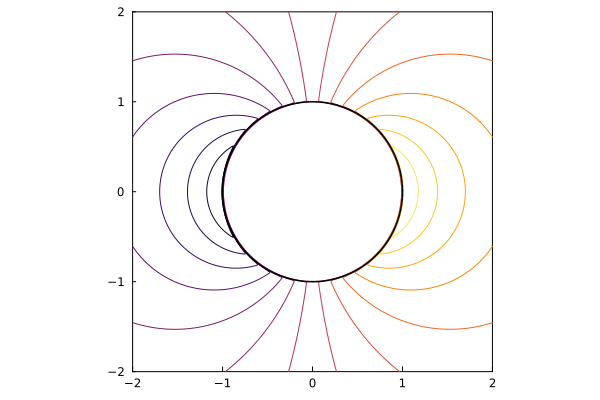

In [8]:
plot(f,cache)

We can see that the field external to the circle has the expected behavior,
and the solution inside the circle is blank, indicating it is zero.

Let's also plot the solution for $s$ on the surface. We will plot the
'raw' result, which is rather noisy, and also apply the filtering matrix $C = \tilde{R}^T R$
several times to smooth it out.

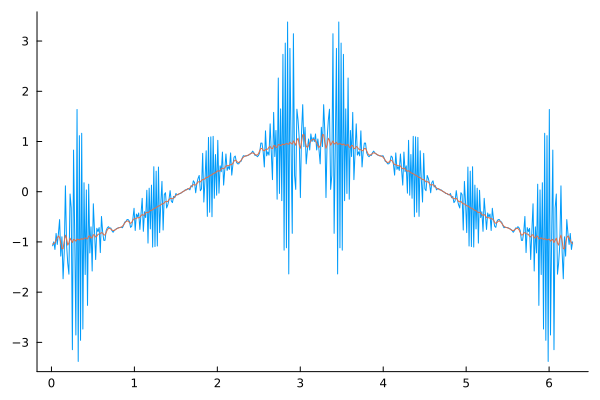

In [9]:
C = create_surface_filter(cache)
plot(s,cache,label="Original solution")
s .= C^5*s;
plot!(s,cache,label="Filtered solution")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*